# Road Accident Risk Prediction — End-to-End ML Pipeline

This notebook presents a complete machine learning workflow for predicting road accident risk using structured tabular data from the Kaggle Playground Series S5E10 competition.

## What this notebook covers

Data loading and quality assessment

Robust preprocessing for numeric and categorical features

Baseline modeling using Ridge Regression with cross-validation

Model improvement using HistGradientBoostingRegressor

Proper model evaluation using RMSE

Generation of a valid Kaggle submission

## Key highlights

Cross-validation was used throughout to ensure reliable performance estimates

Gradient boosting significantly outperformed the linear baseline

The final model achieved strong and stable results with minimal public–private score gap

# Results

Public RMSE: 0.05591

Private RMSE: 0.05615

The close alignment between validation, public, and private scores indicates good generalization and a robust modeling approach.

This notebook is intended to demonstrate practical skills in tabular machine learning, model evaluation, and competition-style workflows.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


# Road Accident Risk Prediction
*Kaggle Playground Series – Season 5, Episode 10*

## Project Overview
This project builds a machine learning pipeline to predict road accident risk
using structured tabular data. The workflow follows a real-world ML process:
data inspection, cleaning, exploratory analysis, feature preprocessing,
model training with cross-validation, and Kaggle submission generation.

## Objectives
- Understand and clean the dataset
- Identify important features and patterns
- Build baseline and improved regression models
- Evaluate performance using cross-validation
- Generate a valid Kaggle submission

## Tools
Python, pandas, numpy, matplotlib, seaborn, scikit-learn

In [2]:
# We import the necessary Libraries and Packages
# For Data Handling
import pandas as pd  
import numpy as np

# For EDA Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# For regression, Feature engineering, and cross validation
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Ridge

sns.set_palette("Set2")
plt.style.use("seaborn-v0_8")
RANDOM_STATE = 42

In [3]:
# We load the datasets into our notebook
# We read the Train dataset
train = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
# Test Dataset
test  = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")
# Submission Dataset
sub  = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")

# We inspect the Train Datasets - rows and targets
# Test Dataset: same features, no target
# Submission: id + target column
train.shape, test.shape, sub.shape

((517754, 14), (172585, 13), (172585, 2))

In [4]:
# We get an overview of the dataset
# We are going to use the Train Dataset
train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [6]:
# We Identify the target column
set(train.columns) - set(test.columns)

{'accident_risk'}

Our target column is 'accident_risk'

In [7]:
# We assign the target column that we found above
TARGET = list(set(train.columns) - set(test.columns))[0]
TARGET

'accident_risk'

In [8]:
# We confirm the distribution for the target column
train["accident_risk"].value_counts(normalize=True)

accident_risk
0.34    0.030018
0.32    0.027503
0.37    0.025983
0.28    0.025663
0.39    0.024141
          ...   
0.94    0.000091
0.97    0.000054
0.96    0.000054
0.90    0.000050
0.93    0.000044
Name: proportion, Length: 98, dtype: float64

In [9]:
# We move to separate the features from the Target
X = train.drop(columns=[TARGET])
y = train[TARGET]

X.shape, y.shape

((517754, 13), (517754,))

## 1. Data Quality Assessment
The dataset was inspected for missing values, duplicates, and inconsistent
data types to ensure reliable modeling.

Note: The preprocessing pipeline uses scikit-learn's ColumnTransformer
to handle numeric and categorical features robustly and is compatible
with recent scikit-learn versions.

In [10]:
# We check for null values 
X.isna().sum().sort_values(ascending=False).head(10)

id                    0
road_type             0
num_lanes             0
curvature             0
speed_limit           0
lighting              0
weather               0
road_signs_present    0
public_road           0
time_of_day           0
dtype: int64

There are no missing values in our dataset

In [11]:
# We check for Duplicates in our dataset
train.duplicated().sum()

np.int64(0)

There are also no duplicates in our dataset

In [12]:
# Numerical Feature overview 
num_cols = train.select_dtypes(include=["int64", "float64"]).columns.tolist()

train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
id,517754.0,258876.500000,149462.849974,0.0,129438.25,258876.50,388314.75,517753.0
num_lanes,517754.0,2.491511,1.120434,1.0,1.00,2.00,3.00,4.0
curvature,517754.0,0.488719,0.272563,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,46.112575,15.788521,25.0,35.00,45.00,60.00,70.0
num_reported_accidents,517754.0,1.187970,0.895961,0.0,1.00,1.00,2.00,7.0
accident_risk,517754.0,0.352377,0.166417,0.0,0.23,0.34,0.46,1.0


We are watching out for:

Unrealistic Values

Heavy skew

Outliers

In [13]:
# Categorical Feature Overview
cat_cols = train.select_dtypes(include=["object"]).columns.tolist()

for col in cat_cols:
    print(f"\n{col}")
    print(train[col].value_counts().head())


road_type
road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64

lighting
lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64

weather
weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64

time_of_day
time_of_day
morning      173410
evening      172837
afternoon    171507
Name: count, dtype: int64


This is mainly for: 

Cardinality check

Rare categories

Encoding strategy planning

In [14]:
# We are going to identify numeric and categorical variables
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

len(num_features), len(cat_features)

(5, 4)

In [15]:
num_features[:5], cat_features[:5]

(['id', 'num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents'],
 ['road_type', 'lighting', 'weather', 'time_of_day'])

In [16]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

## 2. Baseline Model
A Ridge Regression model was used as a baseline to establish a reference
performance using cross-validation.

In [17]:
from sklearn.metrics import root_mean_squared_error

model = Ridge(random_state=RANDOM_STATE)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rmse_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_val)

    rmse = root_mean_squared_error(y_val, preds)
    rmse_scores.append(rmse)

print("CV RMSE mean:", np.mean(rmse_scores))
print("CV RMSE std :", np.std(rmse_scores))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.08156e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.08144e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.08004e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.07986e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


CV RMSE mean: 0.0734991913165173
CV RMSE std : 9.184795242114075e-05


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.08078e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


## 3. Target Exploration
Before improving models, we inspect the target distribution to check for skewness
and decide whether a transformation might improve performance.

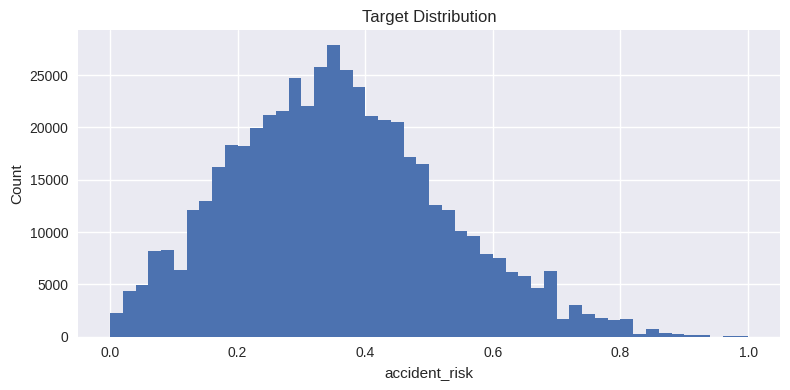

count    517754.000000
mean          0.352377
std           0.166417
min           0.000000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64

In [18]:
# We plot a chart to show the distribution on the target distribution
plt.figure(figsize=(8,4))
plt.hist(y, bins=50)
plt.title("Target Distribution")
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

y.describe()

In [19]:
# We are checking the skew
y.skew()

np.float64(0.37841797634228097)

STEP 13 — Stronger model (recommended): HistGradientBoostingRegressor

This is fast, strong, and built into sklearn (no extra installs).
It also handles non-linear patterns much better than Ridge.

Important note

HistGradientBoosting works only with numeric features, so we’ll:

impute numerics

one-hot encode categoricals (still numeric)

and feed into the model

In [20]:
# Defining the model pipeline 
from sklearn.ensemble import HistGradientBoostingRegressor

hgb_model = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=8,
    max_iter=500,
    random_state=RANDOM_STATE
)

hgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", hgb_model)
])

In [21]:
# Cross validation (Comparing to Ridger Baseline)

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rmse_scores_hgb = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    hgb_pipeline.fit(X_train, y_train)
    preds = hgb_pipeline.predict(X_val)

    rmse = root_mean_squared_error(y_val, preds)
    rmse_scores_hgb.append(rmse)

print("HGB CV RMSE mean:", np.mean(rmse_scores_hgb))
print("HGB CV RMSE std :", np.std(rmse_scores_hgb))

HGB CV RMSE mean: 0.0562768946747859
HGB CV RMSE std : 0.0001037950026159345


### Model Selection
The HistGradientBoostingRegressor significantly outperformed the baseline Ridge
Regression model, reducing cross-validated RMSE from ~0.073 to ~0.056.

Given its superior performance and stability, this model was selected for final
training and submission.

We Train our final model on full data and generate the submission

In [22]:
hgb_pipeline.fit(X, y)
test_preds = hgb_pipeline.predict(test)

submission = sub.copy()
submission[TARGET] = test_preds
submission.head()

,id,accident_risk
0,517754,0.289696
1,517755,0.125326
2,517756,0.183348
3,517757,0.341356
4,517758,0.420465


In [23]:
# We are going to save the submission
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv with shape:", submission.shape)

Saved submission.csv with shape: (172585, 2)


In [24]:
submission.head()
submission.shape

(172585, 2)

## Results Summary

| Model | CV RMSE |
|------|--------|
| Ridge Regression (Baseline) | ~0.073 |
| HistGradientBoostingRegressor | ~0.056 |

The final model achieved a substantial improvement over the baseline,
demonstrating the importance of non-linear models for tabular risk prediction
tasks.

## Kaggle Results

The final model was submitted to the Kaggle Playground Series S5E10 competition.

- **Public RMSE:** 0.05591
- **Private RMSE:** 0.05615

The close alignment between public and private scores indicates good model
generalization and a robust validation strategy.